# Easom function

---
Description:

- Optimization (min)
- Single-objective
- Constraints (no)
---

The general equation is given by:

- $f(x, y) = -\cos(x)\cos(y)\exp\{ -((x-\pi)^2 + (y-\pi)^2) \}$,

with  $-100 \le x, y \le +100$, and global minimum found at: $f(\pi, \pi) = -1.0$.

### First we import python libraries and set up the directory of our code.

In [1]:
import os, sys
import numpy as np
from math import fsum, isclose
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

### Here we import all our custom GA code.

In [2]:
# Import main classes.
from pygenalgo.genome.gene import Gene
from pygenalgo.genome.chromosome import Chromosome
from pygenalgo.engines.auxiliary import cost_function
from pygenalgo.engines.island_model_ga import IslandModelGA

# Import Selection Operator(s).
from pygenalgo.operators.selection.linear_rank_selector import LinearRankSelector

# Import Crossover Operator(s).
from pygenalgo.operators.crossover.uniform_crossover import UniformCrossover

# Import Mutation Operator(s).
from pygenalgo.operators.mutation.gaussian_mutator import GaussianMutator

# Import Migration Operator(s).
from pygenalgo.operators.migration.clockwise_migration import ClockwiseMigration

### Define the Easom function, which plays also the role of the 'fitness' function.

In addition, we define the 'boundary_xy' which takes the role of the 'random()' method of the Genes. Every time
we want to 'mutate' a gene this function will be called and assign a 'valid', but random value for the gene. Here we also define a "check_validity" function that plays the role of checking the genes values and flaging those with invalid values. This example demonstrates how one can use the "correction=True" option.

In [3]:
# Checks the genes for correct ranges.
def check_validity(chromosome: Chromosome) -> bool:

    # Initial flag set to True.
    is_valid = True
    
    # Check if the gene values are out of range.
    for gene in chromosome.genome:

        # This range is problem specific.
        if gene.value < -100.0 or gene.value > +100.0:
            
            # Invalidate the gene.
            gene.is_valid = False

            # If one gene is invalid then the
            # whole chromosome is invalid too.
            is_valid = False
        # _end_if_

    # _end_for_

    return is_valid
# _end_def_

# Easom function.
@cost_function(minimize=True)
def fun_Easom(chromosome):

    # Check if the chromosome has valid genes.
    is_valid = check_validity(chromosome)
    
    # Extract the data values as 'x' and 'y', for parsimony.
    x, y = chromosome.values()
    
    # Calculate the function value.
    f_value = -np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

    # Condition for termination.
    # NOTE: if the chromosome has invalid genes we can't consider it as good solution.
    solution_found = isclose(f_value, -1.0, rel_tol=1.0e-5) if is_valid else False
    
    # Return the solution tuple.
    return f_value, solution_found
# _end_def_

Here we set the GA parameters, such as number of genes, number of chromosomes, etc.

In [4]:
# Random number generator.
rng = np.random.default_rng()

# Random boundary function: ~U(-100, +100).
boundary_xy = lambda: rng.uniform(-100.0, 100.0)

# Define the number of chromosomes.
N = 200

# Draw random samples for the initial points.
xy_init = rng.uniform(-100.0, +100.0, size=(N, 2))

# Initial population.
population = [Chromosome([Gene(xy_init[i, 0], boundary_xy),
                          Gene(xy_init[i, 1], boundary_xy)], np.nan, True)
              for i in range(N)]

# Create the IslandModelGA object that will carry on the optimization.
test_GA = IslandModelGA(initial_pop=population,
                        fit_func=fun_Easom, num_islands=4,
                        select_op=LinearRankSelector(),
                        mutate_op=GaussianMutator(),
                        crossx_op=UniformCrossover(),
                        migrate_op=ClockwiseMigration())

### Optimization process.

Here we call the GA object (either directly, or through the method run()). We set a number of parameter, such as the maximum iterations (i.e. epochs), tolerance for the fitness convergences, etc.

In [5]:
test_GA(epochs=1500, elitism=True, f_tol=1.0e-6, allow_migration=True, correction=True, adapt_probs=True)

Parallel evolution in progress with 4 islands ...
Final Avg. Fitness = 0.8503.
Elapsed time: 3.927 seconds.


In [6]:
# Extract the optimal solution from the GA.
optimal_solution = test_GA.best_chromosome()

# Extract the fitness value from the optimal solution.
optimal_fit = -optimal_solution.fitness

# Display the (final) optimal value.
print(f"Minimum Found: {optimal_fit:.5f}\n")

# Display each gene value separately.
for i, xi in enumerate(optimal_solution.values()):
    print(f"x{i} = {xi:.5f}")
# _end_for_

# True minimum: f(\pi, \pi) = -1.0

Minimum Found: -1.00000

x0 = 3.14179
x1 = 3.14122


### Contour plot: With the "True" global minimum showed as "x" on the plot and "Optimal" as "*".

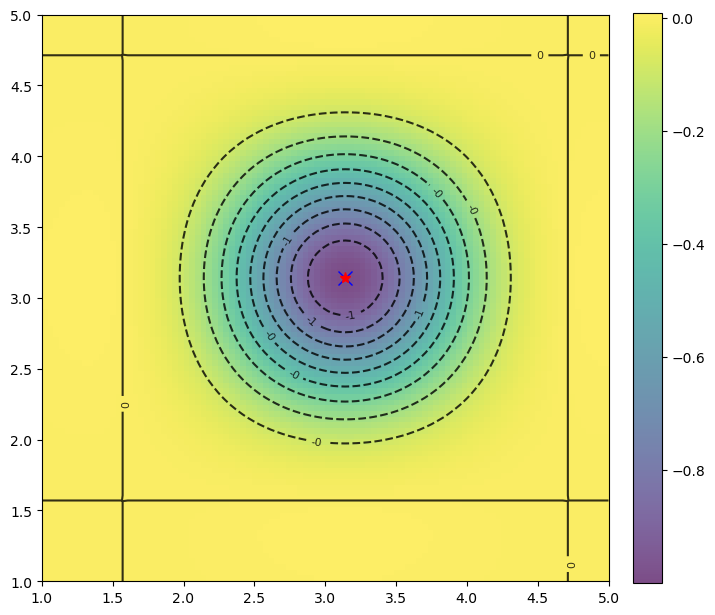

<Figure size 640x480 with 0 Axes>

In [7]:
# Create a grid of x,y points.
x, y = np.array(np.meshgrid(np.linspace(1.0, 5.0, 100),
                            np.linspace(1.0, 5.0, 100)))

# Calculate the function value at (x,y).
z = -np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

# These should be ~ 3.14.
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]

# Plot the contour.
plt.figure(figsize=(8, 8))
im = plt.imshow(z, extent=[1.0, 5.0, 1.0, 5.0],
                origin='lower', cmap='viridis', alpha=0.7)
plt.colorbar(im,fraction=0.046, pad=0.04)

# Plot the "True" minimum.
plt.plot(x_min, y_min, marker='x', markersize=10, color="blue")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.8)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

# Plot the "Optimal" minimum.
x_opt, y_opt = optimal_solution.values()
plt.plot(x_opt, y_opt, marker='*', markersize=8, color="red")

plt.show()
plt.savefig("Easom_optimal.pdf", format="pdf", dpi=300)

### End of file